In [185]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [186]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [187]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['diabetes','healthy']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

In [188]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [189]:
# Setup directory paths to train and test images
train_dir = '/data/hang/Nail_fold/dataset/data_concat_3x3/train'
test_dir = '/data/hang/Nail_fold/dataset/data_concat_3x3/test'
val_dir = '/data/hang/Nail_fold/dataset/data_concat_3x3/val'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [190]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [191]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)
  val_data = datasets.ImageFolder(val_dir, transform=transform)
  print (train_data)
  # Get class names
  class_names = train_data.classes
  print(class_names)
  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )
  val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )
  return train_dataloader, test_dataloader, val_dataloader, class_names

In [192]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained,val_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


Dataset ImageFolder
    Number of datapoints: 3328
    Root location: /home/oem/hang/Nail_fold/dataset_concat/data_concat_3x3/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
['diabetes', 'healthy']


In [193]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=20,
                                      device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2003 | train_acc: 0.9276 | test_loss: 0.2353 | test_acc: 0.8846
Epoch: 2 | train_loss: 0.0606 | train_acc: 0.9877 | test_loss: 0.1916 | test_acc: 0.9159
Epoch: 3 | train_loss: 0.0381 | train_acc: 0.9943 | test_loss: 0.1968 | test_acc: 0.8990
Epoch: 4 | train_loss: 0.0275 | train_acc: 0.9955 | test_loss: 0.1513 | test_acc: 0.9471
Epoch: 5 | train_loss: 0.0220 | train_acc: 0.9970 | test_loss: 0.1675 | test_acc: 0.9255
Epoch: 6 | train_loss: 0.0173 | train_acc: 0.9979 | test_loss: 0.1433 | test_acc: 0.9399
Epoch: 7 | train_loss: 0.0145 | train_acc: 0.9988 | test_loss: 0.1339 | test_acc: 0.9495
Epoch: 8 | train_loss: 0.0122 | train_acc: 0.9991 | test_loss: 0.1619 | test_acc: 0.9303
Epoch: 9 | train_loss: 0.0106 | train_acc: 0.9994 | test_loss: 0.1553 | test_acc: 0.9303
Epoch: 10 | train_loss: 0.0093 | train_acc: 0.9997 | test_loss: 0.1504 | test_acc: 0.9327
Epoch: 11 | train_loss: 0.0080 | train_acc: 1.0000 | test_loss: 0.1409 | test_acc: 0.9375
Epoch: 12 | train_l

pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


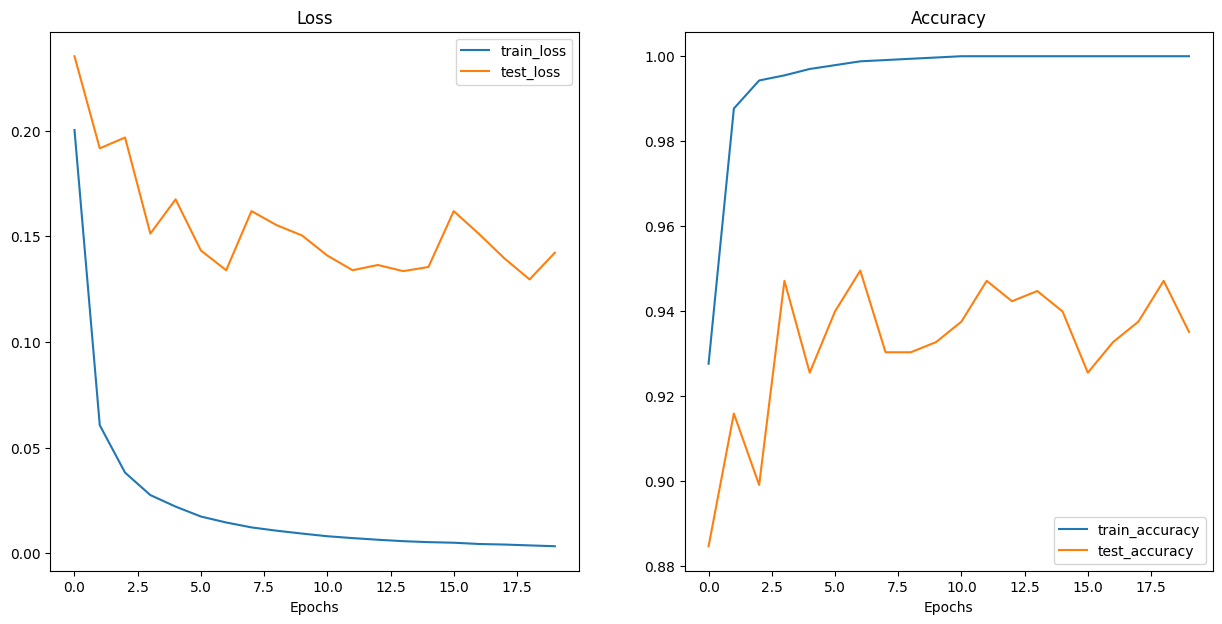

In [194]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

In [195]:
# Generate testing accuracy, predicted label, confusion matrix, and table for classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import numpy as np

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

y_test, y_pred = test_label_predictions(pretrained_vit, device, test_dataloader_pretrained)
cm=confusion_matrix(y_test, y_pred)
cr=classification_report(y_test, y_pred)
fs=f1_score(y_test,y_pred,average='weighted')
rs=recall_score(y_test, y_pred,average='weighted')
accuracy=accuracy_score(y_test, y_pred)
print('Confusion matrix:')
print(cm)
print(cr)
print('F1 score: %f' % fs)
print('Recall score: %f' % rs)
print('Accuracy score: %f' % accuracy)

Confusion matrix:
[[294   4]
 [ 23  95]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       298
           1       0.96      0.81      0.88       118

    accuracy                           0.94       416
   macro avg       0.94      0.90      0.92       416
weighted avg       0.94      0.94      0.93       416

F1 score: 0.933257
Recall score: 0.935096
Accuracy score: 0.935096
